In [20]:
from trafficgraphnn.sumo_network import SumoNetwork
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

sn = SumoNetwork(
    'data/networks/one_intersection/one_intersection.net.xml', routefile='data/networks/one_intersection/one_intersection_rand_routes.routes.xml',
    lanewise=True, addlfiles=['data/networks/one_intersection/one_intersections_additionals.add.xml', 'data/networks/one_intersection/tls_output.add.xml']
)

sn.run()
sn.load_data_to_graph()
graph = sn.get_graph()

2018-05-31 17:21:06,534 trafficgraphnn.sumo_network WARNING  Seed not set, SUMO seed will be random.


In [21]:
# Pick a lane to observe

lane = '1/3to1/2_0'
df_detector = pd.DataFrame()
df_detector = graph.node[lane]['detectors']['e1_1-3to1-2_0_1']['data_series']
df_rows, df_columns = df_detector.shape #get rows and columns

df_e2_detector = pd.DataFrame()
df_e2_detector = graph.node[lane]['detectors']['e2_1-3to1-2_0_0']['data_series']

df_e1_stopbar = pd.DataFrame()
df_e1_stopbar = graph.node[lane]['detectors']['e1_1-3to1-2_0_0']['data_series']

#### Embed the trafficlights #####

graph.edges(lane)
lane_out = '1/2to1/1_1' #choose which connection data you want
df_traffic_lights = graph.edges[(lane, lane_out)]['switch_times'] 

In [22]:
### Automatically detection of Breakpoint A, B, C ###
# This cell can become much faster and efficient. I have to do this, when we implement this code in online-estimation

##Attention!!! : Works only when simulation timestep =1 second!

detector_occupancy_time = []

#print(occ_t[t].values) #debug
nVehEnter_t = df_detector.loc[:, 'nVehEntered']
nVehPassed_t = df_detector.loc[:, 'nVehContrib']

#initialize the storage:
arr_breakpoint_A = np.zeros(39)
arr_breakpoint_B = np.zeros(39)
arr_breakpoint_C = np.zeros(39)

phase_length = int(df_traffic_lights['begin'].values[1] - df_traffic_lights['begin'].values[0])
duration_green_light = int(df_traffic_lights['duration'].values[0])

for num_phase in range(0, 39):

    start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
    end = start + phase_length #seconds #end is end of green phase

    #Calculate detector occupancy time and binary occupancy
    detector_occupancy_time = []
    occ_t = df_detector.loc[:, 'occupancy']
    binary_occ_t = pd.Series()
    binary_occ_t = occ_t.apply(lambda x:(1 if x >= 100 else 0))

    #Calculate effective detector occupancy time
    cnt=0
    for t in range(0, df_rows):
        if binary_occ_t[t].values[0]==0:
            detector_occupancy_time.append(0)
        else:
            if binary_occ_t[t+1].values[0] == 1:
                detector_occupancy_time.append(cnt)
                cnt = cnt+1  
            else:
                detector_occupancy_time.append(cnt)
                cnt=0
    
    #Calculating the time gap between vehicles
    #I am assuming that there is maximum only one vehicle per second on the detector
    point_of_time = []
    time_gap_vehicles = []
    bool_start_timer =0
    time_cnt=0

    for t in range(0, df_rows):
        if nVehEnter_t[t].values[0] ==1: #new vehicle enters the detector: start timer new timer and save old measurements
            time_gap_vehicles.append(time_cnt)
            point_of_time.append(t)
            time_cnt=0 #reset time counter for new timing

        if nVehEnter_t[t].values[0]==0: #timer is running, following vehicle hasn't come yet
            time_cnt= time_cnt+1    

    ### Characterize the Breakpoints A,B ###
    ### A & B ### use the binary occupancy: 
    #We should point out that second-by-second percentage occupancy data can also be utilized to identify point A, i.e., the occupancy value
    #is kept at 100% for more than 3 s.(Liu paper, page 417)
    bool_A_found = 0
    bool_B_found = 0
    breakpoint_A = 0
    breakpoint_B = 0

    for t in range(start, end):

        if bool_A_found == 0 and binary_occ_t[t].values[0] == 0 and binary_occ_t[t+1].values[0] == 1 and binary_occ_t[t+2].values[0] == 1 and binary_occ_t[t+3].values[0] == 1:
            breakpoint_A = t
            bool_A_found = 1

        if bool_A_found == 1 and bool_B_found == 0 and binary_occ_t[t-3].values[0] == 1 and binary_occ_t[t-2].values[0] == 1 and binary_occ_t[t-1].values[0] == 1 and binary_occ_t[t].values[0] == 0:
            breakpoint_B = t
            bool_B_found = 1
            
    if bool_A_found == 1 and bool_B_found == 1:   
        print("breakpoints in phase", num_phase, )
        print('Breakpoint A:', breakpoint_A, 'Breakpoint B:', breakpoint_B)
        arr_breakpoint_A[num_phase]=breakpoint_A  #store breakpoints
        arr_breakpoint_B[num_phase]=breakpoint_B  #store breakpoints
    else:
        print("No reliable breakpoints in phase", num_phase, "found!")
        arr_breakpoint_A[num_phase]= -1  #store breakpoints
        arr_breakpoint_B[num_phase]= -1  #store breakpoints        
        
    ### Characterizing Breakpoint C ### using time gap between consecutive vehicles
    bool_C_found =0
    breakpoint_C = 0
    start_search = breakpoint_B + 10 #start searching for C after the breakpoint B + 10 seconds and until end; little offset of 10 sec is necessary to avoid influence from breakpoint B
    end_search = end + 50

    ###ATTENTION!! Breakpoint k-1 chosen!!! (alternative k)
    for k in range(0, len(point_of_time)-1):
        if point_of_time[k] >= start_search and point_of_time[k] <= end_search and time_gap_vehicles[k] >= 4 and time_gap_vehicles[k] >= time_gap_vehicles[k+1] and time_gap_vehicles[k] >= time_gap_vehicles[k-1] and bool_C_found ==0 and bool_B_found ==1:
            print("Breakpoint C found! Breakpoint:", point_of_time[k-1], "Time Gap:", time_gap_vehicles[k-1])
            breakpoint_C = point_of_time[k-1]
            index_C = k-1
            bool_C_found = 1
            arr_breakpoint_C[num_phase] = breakpoint_C  #store breakpoints

    if bool_C_found == 0:
        print("No breakpoint C in phase", num_phase, "found!") 
        arr_breakpoint_C[num_phase] = -1  #store breakpoints
        
    ### PLOT ###
    
    #fig = plt.figure()
    #fig.set_figheight(5)
    #fig.set_figwidth(12)

    #Plot binary_occ_t
    #plt.subplot(1,2,1)
    #plt.plot(df_detector['end'][start:end_search+20], binary_occ_t[start:end_search+20], c='b')
    #plt.ylabel("binary occupancy")
    #plt.xlabel("time")
    #plt.xlim((start,end_search+20))
    #plt.axvspan(start, end-df_traffic_lights['duration'].values[0], alpha=0.5, color='red')
    #plt.axvspan(end-df_traffic_lights['duration'].values[0], end, alpha=0.5, color='green')
    #plt.axvspan(end, end+phase_length-df_traffic_lights['duration'].values[0], alpha=0.5, color='red')
    #plt.axvspan(end+phase_length-df_traffic_lights['duration'].values[0], end+phase_length, alpha=0.5, color='green')
    #if bool_A_found == 1 and bool_B_found == 1:
    #    plt.plot(breakpoint_A, 0, 'r*')
    #    plt.plot(breakpoint_B, 0, 'r*') 
        
        
    #plt.subplot(1,2,2)
    #plt.plot(point_of_time, time_gap_vehicles, c='b')
    #plt.ylabel("time gap between consecutive vehicles")
    #plt.xlabel("time")
    #plt.xlim((start,end_search+20))
    #plt.axvspan(start, end-df_traffic_lights['duration'].values[0], alpha=0.5, color='red')
    #plt.axvspan(end-df_traffic_lights['duration'].values[0], end, alpha=0.5, color='green')
    #plt.axvspan(end, end+phase_length-df_traffic_lights['duration'].values[0], alpha=0.5, color='red')
    #plt.axvspan(end+phase_length-df_traffic_lights['duration'].values[0], end+phase_length, alpha=0.5, color='green')
    #plt.plot(breakpoint_C, time_gap_vehicles[index_C], 'r*')
            
    #plt.show() 

# put all arrays in a dataframe
df_breakpoints = pd.DataFrame()
df_breakpoints['breakpoint_A'] = arr_breakpoint_A
df_breakpoints['breakpoint_B'] = arr_breakpoint_B
df_breakpoints['breakpoint_C'] = arr_breakpoint_C
#df_breakpoints.head()

breakpoints in phase 0
Breakpoint A: 137 Breakpoint B: 157
Breakpoint C found! Breakpoint: 178 Time Gap: 8
No reliable breakpoints in phase 1 found!
No breakpoint C in phase 1 found!
breakpoints in phase 2
Breakpoint A: 318 Breakpoint B: 336
Breakpoint C found! Breakpoint: 361 Time Gap: 4
breakpoints in phase 3
Breakpoint A: 411 Breakpoint B: 427
Breakpoint C found! Breakpoint: 441 Time Gap: 0
breakpoints in phase 4
Breakpoint A: 485 Breakpoint B: 517
Breakpoint C found! Breakpoint: 533 Time Gap: 1
breakpoints in phase 5
Breakpoint A: 597 Breakpoint B: 607
Breakpoint C found! Breakpoint: 623 Time Gap: 1
breakpoints in phase 6
Breakpoint A: 674 Breakpoint B: 696
Breakpoint C found! Breakpoint: 707 Time Gap: 5
No reliable breakpoints in phase 7 found!
No breakpoint C in phase 7 found!
breakpoints in phase 8
Breakpoint A: 868 Breakpoint B: 876
Breakpoint C found! Breakpoint: 884 Time Gap: 2
No reliable breakpoints in phase 9 found!
No breakpoint C in phase 9 found!
breakpoints in phase 10

v3 =  5.626
real_max_queue:  172.5043126078152
Estimated v_2:  5.545454545454546
Liu method basic model in phase 0
real_max_queue:  127.5031875796895
simple input-output method in Phase 1
real_max_queue:  180.0045001125028
Estimated v_2:  5.809523809523809
Liu method basic model in phase 2
real_max_queue:  172.5043126078152
Estimated v_2:  5.545454545454546
Liu method basic model in phase 3
real_max_queue:  195.00487512187803
Estimated v_2:  5.545454545454546
Liu method basic model in phase 4
real_max_queue:  172.5043126078152
Estimated v_2:  5.545454545454546
Liu method basic model in phase 5
real_max_queue:  142.50356258906473
Estimated v_2:  5.809523809523809
Liu method basic model in phase 6
real_max_queue:  120.00300007500186
simple input-output method in Phase 7
real_max_queue:  150.00375009375233
Estimated v_2:  5.809523809523809
Liu method basic model in phase 8
real_max_queue:  112.50281257031425
simple input-output method in Phase 9
real_max_queue:  150.00375009375233
Estimat

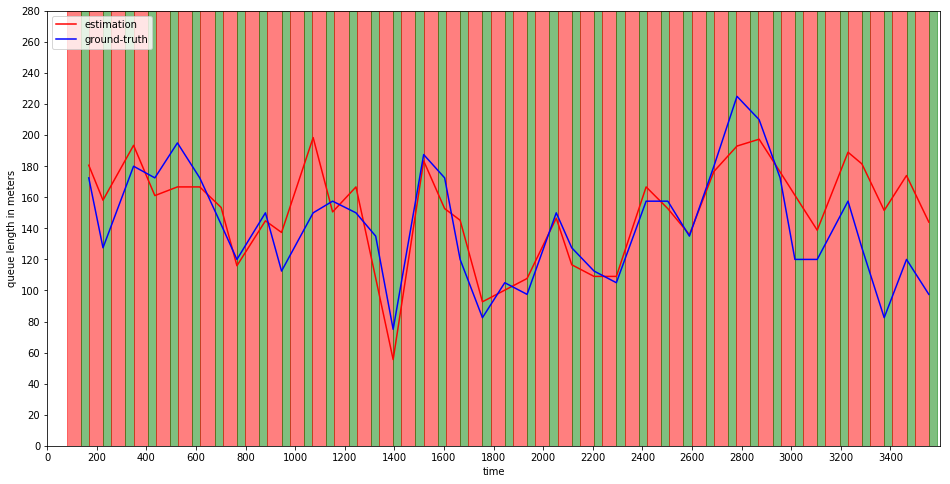

In [23]:
### Implementing queue length estimation ###

#assumptions
v_3 =  5.626
print('v3 = ', v_3)
k_j = 0.13333 #jam density
L_d = 122 #meters; distance from stopbar to e1 detector


#initializing
time_max_queue = np.zeros(39) #initialize value + 39 phases
estimated_max_queue_meters = np.zeros(39)
estimated_max_queue_nVeh = np.zeros(39)
real_max_queue_meters = np.zeros(39)
real_max_queue_nVeh = np.zeros(39)


phase_length = int(df_traffic_lights['begin'].values[1] - df_traffic_lights['begin'].values[0])
duration_green_light = int(df_traffic_lights['duration'].values[0])
start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
end = start + phase_length #seconds #end is end of green phase

for num_phase in range(0, 39): #39 phases

    start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
    end = start + phase_length #seconds #end is end of green phase
    
    real_max_queue_nVeh[num_phase] = sum(df_e2_detector['startedHalts'][start:end])
    real_max_queue_meters[num_phase] = real_max_queue_nVeh[num_phase]/k_j
    print('real_max_queue: ', real_max_queue_meters[num_phase])
    
    #print('start:', start, ' end:', end)
    
    #check if breakpoint A exists
    if arr_breakpoint_A[num_phase] == -1: #no breakpoint A exists -> short queue estimation method
        
        #simple input-output method
        print('simple input-output method in Phase', num_phase)
        #output, vehicles who are leaving the lane during green phase can be max 17
        #input is number of vehicles who pass the detector
        old_estimated_queue_nVeh = estimated_max_queue_nVeh[num_phase-1] #-2, because num_phase starts at 1
        #old estimation without stopbar e1 detector
        #estimated_queue_nVeh = max(old_estimated_queue_nVeh - 17 + sum(df_detector["nVehContrib"][start-duration_green_light-8:start-8]), 0)+ sum(df_detector["nVehContrib"][start-8:end-duration_green_light])
        #new estimation with stopbar e1 detector
        estimated_queue_nVeh = max(old_estimated_queue_nVeh+sum(df_detector["nVehContrib"][start-duration_green_light:end-duration_green_light])- sum(df_e1_stopbar["nVehContrib"][start-duration_green_light:end-duration_green_light]), 0)   
        
        #store results
        estimated_max_queue_nVeh[num_phase]= estimated_queue_nVeh
        estimated_max_queue_meters[num_phase] = estimated_queue_nVeh/k_j
        time_max_queue[num_phase] = end-duration_green_light
        
    else:
        breakpoint_A = arr_breakpoint_A[num_phase]
        breakpoint_B = arr_breakpoint_B[num_phase]
        
        if arr_breakpoint_C[num_phase] == -1:
            print('OVERSATURATION, no Breakpoint C found!!!')
            #f point C cannot be identified, as we discussed in the last section, the approach is under oversaturation. The queue length under
            #oversaturated condition is difficult to estimate, but it is longer than or equal to the distance that occupied by the maximum
            #dischargeable queue during green time
            
            #we assume that the queue length is equal or bigger than the last estimated queue length
            estimated_max_queue_nVeh[num_phase] = estimated_max_queue_nVeh[num_phase-1]
            estimated_max_queue_meters[num_phase] = estimated_max_queue_nVeh[num_phase-1]/k_j
            time_max_queue[num_phase] = end-duration_green_light            

            
        else:
            breakpoint_C = arr_breakpoint_C[num_phase]
            
            ### Attention!!!-> use abs(v_2)!!! mistake in paper!
            v_2 = L_d/(breakpoint_B-(end-duration_green_light))
            print("Estimated v_2: ", v_2)
      ### Extension I      
            #print('Liu method extension I in phase', num_phase)
            #n is the number of vehicles passing detector between T_ng(start red phase) and T_C (breakpoint C)
            #n = sum(df_detector["nVehEntered"][(end-duration_green_light):breakpoint_C])
            #L_max = n/k_j + L_d
            #T_max = (end-duration_green_light) + L_max/abs(v_2)
      ###
    
      ### Basic Model
            print('Liu method basic model in phase', num_phase)
            L_max = L_d + (breakpoint_C-breakpoint_B)/(1/abs(v_2)+1/v_3)
            T_max = breakpoint_B + (L_max-L_d)/abs(v_2)
        
      ### 
            #store results
            estimated_max_queue_meters[num_phase] = L_max
            estimated_max_queue_nVeh[num_phase] = L_max*k_j
            time_max_queue[num_phase] = T_max
            
print(estimated_max_queue_nVeh)
print(estimated_max_queue_meters)
print(time_max_queue)

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)
estimation, = plt.plot(time_max_queue, estimated_max_queue_meters, c='r', label= 'estimation')
#plt.plot(df_e2_detector['end'], df_e2_detector['meanMaxJamLengthInVehicles']/k_j, c='b')
ground_truth, = plt.plot(time_max_queue, real_max_queue_meters, c='b', label= 'ground-truth')

plt.xlabel('time')
plt.ylabel('queue length in meters')
plt.xticks(np.arange(0, 3600, 200))
plt.yticks(np.arange(0, 300, 20))
plt.xlim(0,3600)
for num_phase in range(0,39):
    start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
    end = start + phase_length #seconds #end is end of green phase
    plt.axvspan(start, end-df_traffic_lights['duration'].values[0], alpha=0.5, color='red')
    plt.axvspan(end-df_traffic_lights['duration'].values[0], end, alpha=0.5, color='green')
plt.legend(handles=[estimation, ground_truth])
#plt.grid()
plt.show()